# Unit Quality Metrics

## Tutorial overview

This Jupyter notebook will provide a detailed explanation of the unit quality metrics included in the Allen Institute Neuropixels Visual Coding dataset. It's important to pay attention to quality metrics, because failing to apply them correctly could lead to invalid scientific conclusions, or could end up hiding potentially useful data.

To help you avoid these pitfalls, this tutorial will explore how these metrics are calculated, how they can be biased, and how they should be applied to specific use cases. It's important to keep in mind that none of these metrics are perfect, and that the use of unit quality metrics for filtering ephys data is still an evolving area of research. More work  is required in order to establish general-purpose best practices and standards in this domain.

This tutorial assumes you've already created a data cache, or are working with the files on AWS. If you haven't reached that step yet, we recommend going through the [data access tutorial](./ecephys_data_access.ipynb) first.

Functions related to data analysis will be covered in other tutorials. For a full list of available tutorials, see the [SDK documentation](https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html).

## Why do we need quality metrics?

For a long time, converting continuous voltage traces to sorted spike times was one of the "dark arts" of neuroscience. Spikes were typically sorted by hand-drawing boundaries around clouds of dots, using heuristics learned from other lab members. The quality of the resulting clusters could be validated by looking at metrics such as ISI violations or isolation distance, but there were no standards governing how these metrics informed which units to include for further analysis.

Recent in advances in neural recording devices, such as Neuropixels, have made it practically impossible to sort spikes by hand. Fortunately, we now have access to powerful algorithms that use GPUs to sort spikes in approximately the same amount of time it took to record the data. All of the Allen Institute Neuropixels data has been sorted with [Kilosort2](https://github.com/MouseLand/Kilosort2), a template-matching algorithm developed by Marius Pachitariu at HHMI Janelia Research Campus.

For Neuropixels recordings with minimal electrode drift, Kilosort2 performs well enough that further manual curation is not necessary. Unlike the original version of Kilosort, which required a manual merging step, Kilosort2 attempts to merge units automatically. Sometimes it over-merges, leading to units that clearly combine spikes from multiple cells. But in the majority of cases, Kilosort2 makes merging decisions as well as a human would, and does so in a way that is highly reproducible.

Because there is no "ground truth" information available in these datasets, any sorting algorithm is bound to make mistakes. Quality metrics allow us to understand the types of mistakes that are occurring, and obtain an estimate of their severity. Some common errors that can be identified by quality metrics include:

* Assigning spikes from multiple neurons to the same cluster
* Missing spikes from neurons with waveform amplitude near the spike detection threshold
* Failing to track neurons with waveforms that change as a result of electrode drift

These mistakes can occur even in units that appear to be extremely well isolated. It's misleading to conceive of units as existing in two distinct categories, one with perfectly clean "single units" and one with impure "multiunits." Instead, there's a gradient of qualities, with mostly complete, uncontaminated units at one end, and incomplete, highly contaminated units at the other.

Despite the fact that there's not a clear division between single-unit and multi-unit activity, we still have to make a binary decision in every analysis we carry out: should this unit be included or not? Ideally this decision should be based on objective metrics that will not bias the end results. By default, the AllenSDK uses three quality metrics, `isi_violations`, `amplitude_cutoff`, and `presence_ratio`, to filter out units that are likely to be highly contaminated or missing lots of spikes. However, the default values of these filters may not be appropriate for your analysis, or you may want to disable them entirely. Reading through this tutorial will give you a better understanding of how these (and other) metrics should be applied, so you can apply them effectively throughout your own explorations of this dataset.

Metrics covered in this tutorial:
* <a href='#Firing-rate'>Firing rate</a> (`firing_rate`)
* <a href='#Presence-ratio'>Presence ratio</a> (`presence_ratio`)
* <a href='#Amplitude-cutoff'>Amplitude cutoff</a> (`amplitude_cutoff`)
* <a href='#ISI-violations'>ISI violations</a> (`isi_violations`)
* <a href='#SNR'>SNR</a> (`snr`)
* <a href='#Isolation-distance'>Isolation distance</a> (`isolation_distance`)
* <a href='#d-prime'>d-prime</a> (`d_prime`)
* <a href='#Nearest-neighbors-hit-rate'>Nearest-neighbors-hit-rate</a> (`nn_hit_rate`)

## How these metrics were calculated

The Python code used to calculate these metrics from the outputs of Kilosort2 is available in the [ecephys_spike_sorting](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/quality_metrics) repository. A number of the metrics are based on the waveform principal components, which are not included in the data release. To recompute these metrics on your own, you'll need access to the raw data, which is available in the [Allen Brain Observatory S3 Bucket on AWS](https://registry.opendata.aws/allen-brain-observatory/). 

This code was recently incorporated into the [SpikeMetrics](https://github.com/SpikeInterface/spikemetrics) repository by the SpikeInterface team. It's now available as a PyPi package (`pip install spikemetrics`) if you'd like to try them out on your own data.

If you have any questions about the specific implementation of these metrics, or recommendations for new ones to include, we encourage you to submit an issue in either GitHub repository.

## Accessing the metrics

Because these metrics are so important to interpreting your results, they are included in every DataFrame that stores information about individual units.

To take a look at the metrics for all units in the dataset, simply call `get_units()` on the `EcephysProjectCache` object.

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [2]:
# Example cache directory path, it determines where downloaded data will be stored
data_directory = '/local1/ecephys_cache_dir/'

manifest_path = os.path.join(data_directory, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

units = cache.get_units()

In [3]:
len(units)

40010

By default, the AllenSDK applies filters so only units above a set of thresholds are returned.

The default filter values are as follows:

- `isi_violations` < 0.5
- `amplitude_cutoff` < 0.1
- `presence_ratio` > 0.9

Let's disable these filters so we can see all of the available units:

In [4]:
units = cache.get_units(amplitude_cutoff_maximum = np.inf,
                        presence_ratio_minimum = -np.inf,
                        isi_violations_maximum = np.inf)

len(units)

99180

Now we have a DataFrame that contains all of the units detected by Kilosort2 across 58 experiments. Importantly, this does not include units with invalid waveforms. Kilosort2 often detects "spikes" that are very clearly not associated with action potentials; these can result from electrical artifacts or lower-frequency voltage fluctuations that cross the spike detection threshold. The majority of these "noise" units are automatically filtered out via [this module](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/noise_templates), followed by a manual inspection step to identify any remaining artifactual waveforms.

Let's look in more detail at the distribution of some quality metrics across 99,180 units. We'll start by creating a function for plotting each metric in an aesthetically pleasing way:

In [5]:
from scipy.ndimage.filters import gaussian_filter1d
plt.rcParams.update({'font.size': 14})

def plot_metric(data, bins, x_axis_label, color, max_value=-1):
    
    h, b = np.histogram(data, bins=bins, density=True)

    x = b[:-1]
    y = gaussian_filter1d(h, 1)

    plt.plot(x, y, color=color)
    plt.xlabel(x_axis_label)
    plt.gca().get_yaxis().set_visible(False)
    [plt.gca().spines[loc].set_visible(False) for loc in ['right', 'top', 'left']]
    if max_value < np.max(y) * 1.1:
        max_value = np.max(y) * 1.1
    plt.ylim([0, max_value])
    
    return max_value

## Firing rate

First, let's take a look at firing rate, which is the most straightforward metric to compute. Firing rate is equal to the total number of spikes divided by the number of seconds in the recording. We'll create a density plot of firing rate across all units in the dataset:

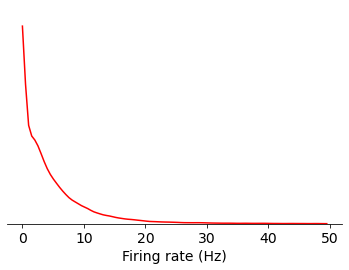

In [6]:
data = units['firing_rate']
bins = np.linspace(0,50,100)

max_value = plot_metric(data, bins, 'Firing rate (Hz)', 'red')

Since there are many units with low firing rates, let's use a log scale instead:

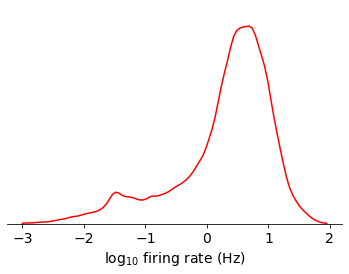

In [7]:
data = np.log10(units['firing_rate'])
bins = np.linspace(-3,2,100)

max_value = plot_metric(data, bins, 'log$_{10}$ firing rate (Hz)', 'red')

Based on this plot, you can clearly see the approximately lognormal distribution of firing rates, which [has been described previously](http://www.buzsakilab.com/content/PDFs/Mizuseki2014.pdf). However, there's more weight on the lower tail of the distribution, which is likely due to some units missing spikes as a result of thresholding or drift. If we filter out contaminated units using another metric, `nn_hit_rate` (more on what this means later), the distribution becomes almost perfectly lognormal:

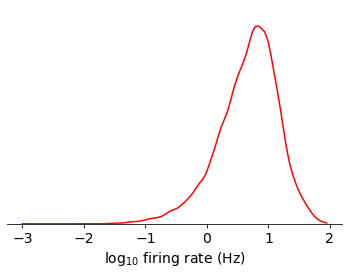

In [8]:
data = np.log10(units[units.nn_hit_rate > 0.9]['firing_rate'])
bins = np.linspace(-3,2,100)

max_value = plot_metric(data, bins, 'log$_{10}$ firing rate (Hz)', 'red')

Before we move on to the next metric, let's add one more feature to these plots. Displaying the metrics separately for different brain regions can be helpful for understanding the variation that results from the physiological features of the area we're recording from. The four main regions that are part of the Neuropixels Visual Coding dataset are cortex, thalamus, hippocampus, and midbrain. We'll use the Allen CCF structure acronyms to find the units that belong to each region.

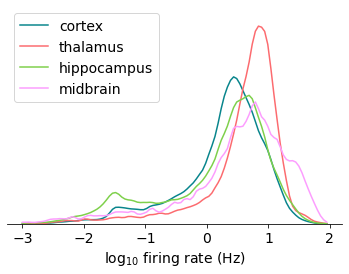

In [9]:
region_dict = {'cortex' : ['VISp', 'VISl', 'VISrl', 'VISam', 'VISpm', 'VIS', 'VISal','VISmma','VISmmp','VISli'],
             'thalamus' : ['LGd','LD', 'LP', 'VPM', 'TH', 'MGm','MGv','MGd','PO','LGv','VL',
              'VPL','POL','Eth','PoT','PP','PIL','IntG','IGL','SGN','VPL','PF','RT'],
             'hippocampus' : ['CA1', 'CA2','CA3', 'DG', 'SUB', 'POST','PRE','ProS','HPF'],
             'midbrain': ['MB','SCig','SCiw','SCsg','SCzo','PPT','APN','NOT','MRN','OP','LT','RPF','CP']}

color_dict = {'cortex' : '#08858C',
              'thalamus' : '#FC6B6F',
              'hippocampus' : '#7ED04B',
              'midbrain' : '#FC9DFE'}

bins = np.linspace(-3,2,100)
max_value = -np.inf

for idx, region in enumerate(region_dict.keys()):
    
    data = np.log10(units[units.ecephys_structure_acronym.isin(region_dict[region])]['firing_rate'])
    
    max_value = plot_metric(data, bins, 'log$_{10}$ firing rate (Hz)', color_dict[region], max_value)
    
_ = plt.legend(region_dict.keys())

We can see a clear separation in the distributions across areas; the thalamus has a lot of units that fire in the 8 Hz range (remember the log scale), while the midbrain has the most units with very high rates (>20 Hz).

Here's a summary of things to keep in mind when using `firing_rate` in your analysis:

**How it can be biased**
* If a unit is poorly isolated, the firing rate will be over-estimated, because contaminating spikes will be included in the calculation
* If a unit's amplitude is close to threshold, the firing rate will be under-estimated, because some spikes will be missing
* If a unit drifts out of the recording, the firing rate will be under-estimated, because spikes will not be detected for a portion of the recording
* If data acquisition is interrupted (true for a small subset of experiments), the firing rate will be under-estimated, because spikes will be missing from gaps in the recording

**How it should be used**
* Firing rate can be used to filter out units that have too few spikes to result in meaningful analysis. In this case, it may be better to use the firing rate for the specific interval you're analyzing, because some units may drift out of the recording at other times.
* High firing rate units tend to be easier to isolate, since there are more spikes available for fitting the template in Kilosort2. However, there are other metrics that measure isolation more directly and would likely to be better to use instead.

## Presence ratio

Presence ratio is not a standard metric in the field, but it's straightforward to calculate and is an easy way to identify incomplete units. It measures the fraction of time during a session in which a unit is spiking, and ranges from 0 to 0.99 (an off-by-one error in the calculation ensures that it will never reach 1.0).

Let's look at the distribution of presence ratio across areas:

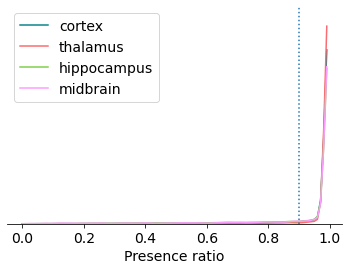

In [10]:
bins = np.linspace(0,1,100)
max_value = -np.inf

for idx, region in enumerate(region_dict.keys()):
    
    data = units[units.ecephys_structure_acronym.isin(region_dict[region])]['presence_ratio']
    
    max_value = plot_metric(data, bins, 'Presence ratio', color_dict[region], max_value)
    
_ = plt.legend(region_dict.keys())

plt.plot([0.9, 0.9],[0,max_value], ':')

It's clear that most units have a presence ratio of 0.9 or higher, which means they are present for at least 90% of the recording. Units with lower presence ratio are likely to have drifted out of the recording, or had waveforms that changed so dramatically they were assigend to separate clusters.

Calculating the exact fraction of units with presence ratio above 0.9 is easy:

In [11]:
np.around(np.sum(units.presence_ratio > 0.9) / len(units), 2)

0.83

Here's a summary of things to keep in mind when using `presence_ratio` in your analysis:

**How it can be biased**
* Just because a unit has a high presence ratio doesn't mean it's immune to drift. If a unit's amplitude drifts closer to the spike detection threshold, it can result in dramatic changes in apparent firing rate, even if the underlying physiology remains the same.
* Sometimes a low presence ratio can result from highly selective spiking patterns (e.g., firing only during running epochs)

**How it should be used**
* If you are analyzing changes in firing rate over the entire recording session, or are comparing responses to stimuli presented at the beginning and end of the experiment, presence ratio is a simple way to exclude units that would bias your results. However, you should also look at other quality metrics, such as <a href='#Amplitude-cutoff'>amplitude cutoff</a>, to check for more subtle effects of electrode drift.
* If you are only analyzing a short segment of the experiment, it may be helpful to disable the default presence ratio filter, in order to maximize the number of units available to you.
* If you're unsure whether a unit has a low presence ratio due to electrode drift or selective firing, plotting its spike amplitudes over time can be informative.

## Amplitude cutoff

Amplitude cutoff provides another way to check for units that are missing spikes. Unlike <a href='#Presence-ratio'>presence ratio</a>, which detects units that drift out of the recording, amplitude cutoff provides an estimate of the false negative rate—e.g., the fraction of spikes below the spike detection threshold. Thus, amplitude cutoff is a measure of unit "completeness" that is complementary to presence ratio.

Let's take a look at the distribution of values for amplitude cutoff across the dataset:

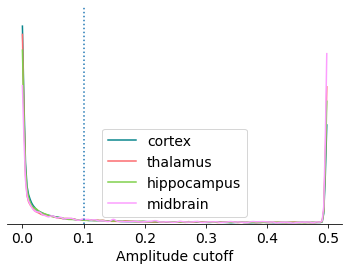

In [12]:
bins = np.linspace(0,0.5,200)
max_value = -np.inf

for idx, region in enumerate(region_dict.keys()):
    
    data = units[units.ecephys_structure_acronym.isin(region_dict[region])]['amplitude_cutoff']
    
    max_value = plot_metric(data, bins, 'Amplitude cutoff', color_dict[region], max_value)
    
_ = plt.legend(region_dict.keys())

plt.plot([0.1, 0.1],[0,max_value], ':')

Amplitude cutoff is calculated from the distribution of spike amplitudes for each unit. This metric measures the degree to which this distribution is truncated, or "cut off," as a proxy for the fraction of missing spikes. So an amplitude cutoff of, say, 0.1 would indicate that approximately 10% of spikes are missing from this unit.

If the peak of the amplitude distribution occurs at its lowest value, it's impossible to estimate the fraction of missing spikes. In this case, the amplitude cutoff is set to 0.5. That explains why there are large peaks at both ends of the distribution, one around 0 and one at 0.5.

We can check the fraction of units with the maximum amplitude cutoff using the following code:

In [13]:
np.around(np.sum(units.amplitude_cutoff == 0.5) / len(units), 2)

0.15

Here's a summary of things to keep in mind when using `amplitude_cutoff` in your analysis:

**How it can be biased**
* The calculation assumes that the amplitude histogram is symmetrical (i.e., it uses the upper tail of the distribution to estimate the fraction of spikes missing from the lower tail). If a unit's waveform amplitude changes as a result of electrode drift, this assumption is usually invalid.
* Amplitude cutoff is only weakly correlated with other measures of unit quality, meaning it's possible to have well-isolated units with high amplitude cutoff.

**How it should be used**
* If you are performing analyses that depends on precise measurements of spike timing, setting a low amplitude cutoff threshold (0.01 or lower) is recommended. This will remove a large fraction of units, but will ensure that the unit of interest contain most of the relevant spikes.

## ISI violations

Inter-spike-interval (ISI) violations are a classic measure of unit contamination. Because all neurons have a biophysical refractory period, we can assume that any spikes occurring in rapid succession (<1.5 ms intervals) come from two different neurons. Therefore, the more a unit is contaminated by spikes from multiple neurons, the higher its `isi_violations` value will be.  

The calculation for ISI violations comes from [Hill et al. (2011) J Neurosci 31: 8699-8705](https://www.jneurosci.org/content/31/24/8699). Rather than reporting the fraction of spikes with ISI violations, their metric reports the relative firing rate of the hypothetical neurons that are generating these violations. You can interpret an ISI violations value of 0.5 as meaning that contamining spikes are occurring at roughly half the rate of "true" spikes for that unit. In cases of highly contaminated units, the ISI violations value can sometimes be even greater than 1.

Let's look at the distribution of ISI violations across the different regions in this dataset:

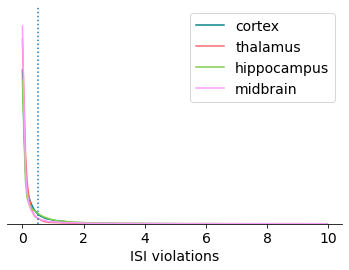

In [14]:
bins = np.linspace(0,10,200)
max_value = -np.inf

for idx, region in enumerate(region_dict.keys()):
    
    data = units[units.ecephys_structure_acronym.isin(region_dict[region])]['isi_violations']
    
    max_value = plot_metric(data, bins, 'ISI violations', color_dict[region], max_value)
    
_ = plt.legend(region_dict.keys())

plt.plot([0.5, 0.5],[0,max_value], ':')

This one looks like a good candidate for plotting on a log scale:

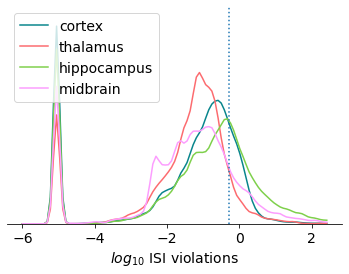

In [15]:
bins = np.linspace(-6,2.5,100)
max_value = -np.inf

for idx, region in enumerate(region_dict.keys()):
    
    data = np.log10(units[units.ecephys_structure_acronym.isin(region_dict[region])]['isi_violations'] + 1e-5) 
    
    max_value = plot_metric(data, bins, '$log_{10}$ ISI violations', color_dict[region], max_value)
    
_ = plt.legend(region_dict.keys())

plt.plot([np.log10(0.5), np.log10(0.5)],[0,max_value], ':')

A few things to note about this plot:

* We've added 0.00001 to the ISI violations values, because the log of 0 is undefined. This creates a peak at -5 for all the units with no ISI violations
* The hippocampus has the most units with high ISI violations, likely due to the density of cells in this structure.
* The default threshold of 0.5 is still quite permissive

If we wanted to only include units with no ISI violations, what percentage would be available for analysis?

In [16]:
np.around(np.sum(units.isi_violations == 0.0) / len(units), 2)

0.14

Here's a summary of things to keep in mind when using `isi_violations` in your analysis:

**How it can be biased**
* As with all metrics, ISI violations may not be stable throughout the experiment. It may be helpful to re-calculate it for the specific epochs you're analyzing.
* Two neurons with similar waveforms, but firing in largely non-overlapping epochs, could end up being merged into the same cluster. In this case, the ISI violations may be low, even though the resulting unit is a highly contaminated. This situation would tricky to catch, but fortunately shouldn't happen very often.

**How it should be used**
* Setting your ISI violations threshold to 0 (or close to it), will help ensure that contaminated units don't make it into your analysis, but will greatly reduce the number of units available. You should think carefully about what degree of contamination your analysis can tolerate without biasing your conclusions. For example, if you are comparing firing rates of individual units across areas, you'll want to set a low ISI violations threshold to prevent contaminating spikes from affecting your estimates. On the other hand, if you're comparing overall firing rates between areas, counting spikes from contaminated clusters may be valid.

## SNR

Signal-to-noise ratio, or SNR, is another classic metric of unit quality. It measures the ratio of the maximum amplitude of the mean spike waveform to the standard deviation of the background noise on one channel. Even though it's widely used in the literature, we don't recommend using it on Neuropixels data for two reasons:

1. It only takes into account the unit's peak channel, despite the fact that waveforms are often spread across a dozen channels or more.
2. If the waveform changes due to drift, peak channel SNR can change dramatically, even though overall isolation quality remains consistent.

Nevertheless, it can still be helpful to look at the distribution of SNRs across areas:

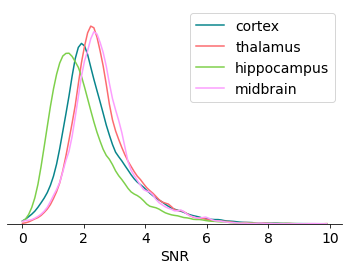

In [17]:
bins = np.linspace(0,10,100)
max_value = -np.inf

for idx, region in enumerate(region_dict.keys()):
    
    data = units[units.ecephys_structure_acronym.isin(region_dict[region])]['snr']
    
    max_value = plot_metric(data, bins, 'SNR', color_dict[region], max_value)
    
_ = plt.legend(region_dict.keys())

We can clearly see an increase in overall SNR from hippocampus to cortex to thalamus and midbrain. These changes likely result from differences in the size, density, and orientation of cell bodies in these regions. A more explicit comparison between extracellular ephys signal quality and histological features would be an interesting research topic.

Here's a summary of things to keep in mind when using `snr` in your analysis:

**How it can be biased**
* SNR only considers information contained in a single channel, and therefore cannot capture isolation quality accurately
* If the peak channel moves across the probe due to electrode drift, SNR will drop.

**How it should be used**
* SNR can be helpful as a point of comparison to the previous literature
* It should not be used to filter data in isolation

That said, a modified version of the SNR metric that is tolerant to electrode drift could be highly informative. Future Allen Institute data releases may include such a metric.

## Isolation distance

Isolation distance is a metric based on the principal components (PCs) of a unit's waveforms. After the spike sorting step is complete, the waveforms for every spike are projected into a lower-dimensional principal component space. By default, Kilosort2 saves the top 3 PCs for 32 channels around each unit's peak channel—this is a huge amount of data, but it's greatly compressed compared to the original 60 samples x 350+ channels for each waveform. PC-based metrics are a useful way of validating cluster quality because, at least for Kilosort2, the original sorting process doesn't rely on the waveform's principal components.

You can imagine each unit's PCs a clusters in a 32 x 3 = 96-dimensional space. Isolation distance calculates the size of the 96-dimensional sphere that includes as many "other" spikes as are contained in the original unit's cluster, after normalizing the clusters by their standard deviation in each dimension (Mahalanobis distance). The higher the isolation distance, the more a unit is separated from its neighbors in PC space, and therefore the lower the likelihood that it's contamined by spikes from multiple units.

Let's look at the range of isolation distances across different brain regions:

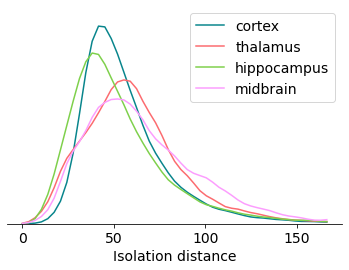

In [18]:
bins = np.linspace(0,170,50)
max_value = -np.inf

for idx, region in enumerate(region_dict.keys()):
    
    data = units[units.ecephys_structure_acronym.isin(region_dict[region])]['isolation_distance']
    
    max_value = plot_metric(data, bins, 'Isolation distance', color_dict[region], max_value)
    
_ = plt.legend(region_dict.keys())

Here's a summary of things to keep in mind when using `isolation_distance` in your analysis:

**How it can be biased**
* Isolation distance is not immune to drift; if a unit's waveform changes as a result of electrode motion, it could reduce isolation distance without necessarily causing the unit to become more contaminated.
* The exact value of isolation distance will depend on the number of PCs used in the calculation; therefore, it's difficult to compare this metric to previous reports in the literature.

**How it should be used**
* Isolation distance is correlated with overall cluster quality, but it's not a direct measure of contamination rate. For this reason, it should be used in conjunction with other metrics, such as `isi_violations`, that more directly measure the likelihood of contaminating spikes.

## d-prime

Like isolation distance, d-prime is another metric calculated for the waveform PCs. It uses linear discriminant analysis to calculate the separability of one unit's PC cluster and all of the others. A higher d-prime value indicates that the unit is better isolated from its neighbors.

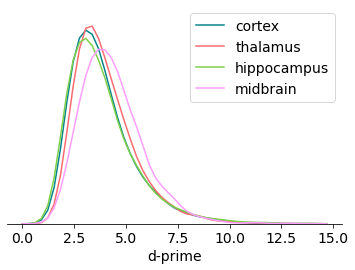

In [19]:
bins = np.linspace(0,15,50)
max_value = -np.inf

for idx, region in enumerate(region_dict.keys()):
    
    data = units[units.ecephys_structure_acronym.isin(region_dict[region])]['d_prime']
    
    max_value = plot_metric(data, bins, 'd-prime', color_dict[region], max_value)
    
_ = plt.legend(region_dict.keys())

Here's a summary of things to keep in mind when using `d_prime` in your analysis:

**How it can be biased**
* Like isolation distance, d-prime is not tolerant to drift. Since a single value of d-prime is computed for the entire session, the d-prime value is actually a lower bound on the true value of this metric computed at any one timepoint.

**How it should be used**
* d-prime, in principal, gives you an estimate of the false positive rate for each unit. However, more work is required to validate this.

## Nearest-neighbors hit rate

Nearest-neighbors hit rate is another PC-based quality metric. It's derived from the 'isolation' metric originally reported in [Chung, Magland et al. (2017)](https://www.sciencedirect.com/science/article/pii/S0896627317307456?via%3Dihub). This metric looks at the PCs for one unit and calculates the fraction of their nearest neighbors that fall within the same cluster. If a unit is highly contaminated, then many of the closest spikes will come from other units. Nearest-neighbors hit rate is nice because it always falls between 0 and 1, making it straightforward to compare across different datasets.

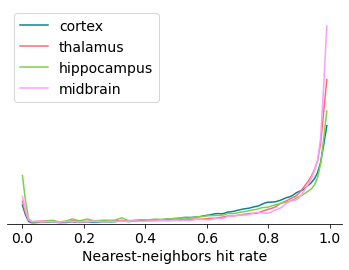

In [20]:
bins = np.linspace(0,1,100)
max_value = -np.inf

for idx, region in enumerate(region_dict.keys()):
    
    data = units[units.ecephys_structure_acronym.isin(region_dict[region])]['nn_hit_rate']
    
    max_value = plot_metric(data, bins, 'Nearest-neighbors hit rate', color_dict[region], max_value)
    
_ = plt.legend(region_dict.keys())

Here's a summary of things to keep in mind when using `nn_hit_rate` in your analysis:

**How it can be biased**
* Like the other PC-based metrics, `nn_hit_rate` can be negatively impacted by electrode drift.

**How it should be used**
* `nn_hit_rate` is a nice proxy for overall cluster quality, but should be used in conjunction with other metrics that measure missing spikes or contamination rate more directly.

## Summary

To summarize, let's take a look at the range of values that each of these metrics takes across the whole dataset:

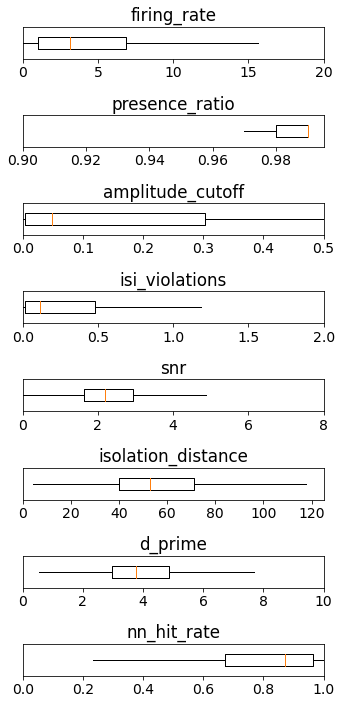

In [21]:
metrics = ['firing_rate', 
           'presence_ratio', 
           'amplitude_cutoff', 
           'isi_violations', 
           'snr', 
           'isolation_distance', 
           'd_prime', 
           'nn_hit_rate']

ranges = [[0,20],
          [0.9,0.995],
          [0,0.5],
          [0,2],
          [0,8],
          [0,125],
          [0,10],
          [0,1]]

_ = plt.figure(figsize=(5,10))

for idx, metric in enumerate(metrics):
    
    data = units[metric].values
    data = data[np.invert(np.isnan(data))]

    _ = plt.subplot(len(metrics),1,idx+1)
    _ = plt.boxplot(data, showfliers=False, showcaps=False, vert=False)
    _ = plt.ylim([0.8,1.2])
    _ = plt.xlim(ranges[idx])
    _ = plt.yticks([])
    
    plt.title(metric)
    
plt.tight_layout()